In [2]:
import torch
from examples.dcgan import batch_size
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

# An Implementation of Transformer [90 points]

To help you gain a deeper understanding of the Transformer model, you will need to implement the code for it in this assignment. The framework is provided,  you only need to implement the core parts of the code.

## Module: MultiHeadAttention [20 points]

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head): #输入特征维度和多头注意力的头数
        super().__init__()
        self.n_head = n_head
        self.w_q = nn.Linear(d_model, d_model) #nn.Linear: input*W^T+b
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model) #输出的线性变换层
        self.d_k = d_model // n_head #定义每个头的向量维度

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0) #输入的q是[batch_size, seq_len, d_model]的
        q = self.w_q(q).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2) 
        #将q经过线性层wq，重塑为[batch_size, n_head, seq_len, d_k]，以便分配给不同的注意力头
        k = self.w_k(k).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)
        v = self.w_v(v).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)

        # TODO: Implement your scaled dot-product attention here
        scores  = torch.matmul(q,k.transpose(-2,-1)/math.sqrt(self.d_k))#通过q和k的内积计算注意力分数
        
        if mask is not None:
            scores = scores.masked_fill(mask==0, float('-inf'))
            
        attention = torch.softmax(scores,dim=-1)
        out = torch.matmul(attention,v)
        out = out.transpose(1,2).contiguous().view(batch_size,-1,self.d_k*self.n_head)
        out = self.w_o(out)
        # Normally you can choose to keep the attention weights or not
        
        return out, attention
    
# Test your MultiHeadAttention here
module = MultiHeadAttention(512, 8)
x = torch.randn(32, 60, 512)  #batch size， seq len， d model（embedding 维度，需要固定）
mask = torch.triu(torch.ones(60, 60), diagonal=1).byte().unsqueeze(0)
y, attn = module(x, x, x, mask)
print(y.size(), attn.size())
# torch.Size([32, 60, 512]) torch.Size([32, 8, 60, 60])

torch.Size([32, 60, 512]) torch.Size([32, 8, 60, 60])


## Module: PositionwiseFeedforward [10 points]

In [6]:
class PositionwiseFeedforward(nn.Module): #在每个token上独立应用前馈神经网络
    def __init__(self, d_model, d_ff): #dff是隐藏层的维度
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # TODO: Implement your position-wise feedforward here
        # Note: You can choose to add dropout or not, it is not necessary here
        # Note: Remember the activate function in the original transformer is ReLU
        x = self.w_1(x)
        x = torch.relu_(x)
        x = self.w_2(x)
        
        return x
    
# Test your PositionwiseFeedforward here
module = PositionwiseFeedforward(512, 2048)
x = torch.randn(32, 60, 512) #batch size， seq len， embedding len
y = module(x)
print(y.size())
#torch.Size([32, 60, 512])

torch.Size([32, 60, 512])


## Module: Positional Encoding and Token Embedding [10 points]

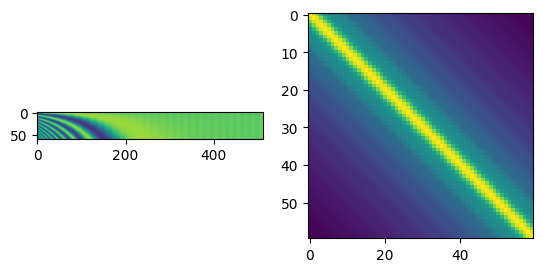

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len): #max len决定编码的范围
        super().__init__()
        self.encoding = nn.Parameter(torch.zeros(max_len, d_model)).requires_grad_(False) #存储位置编码的向量
        position = torch.arange(0, max_len).unsqueeze(1).float()
        _2i = torch.arange(0, d_model, 2).float() #取出所有偶数索引

        # TODO: Implement the positional encoding here
        self.encoding[:, 0::2] = torch.sin(position / (10000 ** (_2i / d_model))) 
        self.encoding[:, 1::2] = torch.cos(position / (10000 ** (_2i / d_model)))

    def forward(self, x):
        return x + self.encoding[:x.size(1), :]
    
# Test your PositionalEncoding here
module = PositionalEncoding(512, 1000)
x = torch.zeros(1, 60, 512)
y = module(x).squeeze(0)
plt.subplot(1, 2, 1)
plt.imshow(y)
plt.subplot(1, 2, 2)
plt.imshow(y @ y.T)

In [13]:
class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len):
        super().__init__()
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.token_embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.positional_encoding(self.token_embedding(x))

# Block: Encoder Layer [10 points]

In [15]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.feed_forward = PositionwiseFeedforward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        attn_out,_ = self.self_attn(x,x,x,mask)
        x = self.norm1(x+attn_out)
        ffn_out = self.feed_forward(x)
        x = self.norm2(x+ffn_out)
        # TODO: Implement your encoder layer here
        # Note: The normalization method is Post-Norm in the original transformer

        return x
    
# Test your EncoderLayer here
module = EncoderLayer(512, 8, 2048)
x = torch.randn(32, 60, 512)
mask = torch.triu(torch.ones(60, 60), diagonal=1).byte().unsqueeze(0)
y = module(x, mask)
print(y.size())
#torch.Size([32, 60, 512])

torch.Size([32, 60, 512])


# Block: Decoder Layer [10 points]

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.cross_attn = MultiHeadAttention(d_model, n_head)
        self.feed_forward = PositionwiseFeedforward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc=None, src_mask=None, tgt_mask=None):
        # TODO: Implement your self attention here
        attn_out,_ = self.self_attn(x,x,x,src_mask)
        x = self.norm1(x+attn_out)
        
        if enc is not None:
            cro_attn,_ = self.cross_attn(x,enc,enc,tgt_mask)
            x = self.norm2(x+cro_attn)
        
        ffn_out = self.feed_forward(x)
        x = self.norm3(x+ffn_out)

        return x
    
# Test your DecoderLayer here
module = DecoderLayer(512, 8, 2048)
x = torch.randn(32, 60, 512)
enc = torch.randn(32, 60, 512)
src_mask = torch.triu(torch.ones(60, 60), diagonal=1).byte().unsqueeze(0)
y = module(x, enc, src_mask)
print(y.size())

torch.Size([32, 60, 512])


# Model: Encoder and Decoder

In [18]:
class Encoder(nn.Module):
    def __init__(self, encoder_vocab_size, max_len, d_model, ffn_hidden, n_head, n_layers):
        super().__init__()
        self.embedding = TransformerEmbedding(encoder_vocab_size, d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_head, ffn_hidden) for _ in range(n_layers)]) #n layers可以控制编码器的深度

    def forward(self, x, mask=None):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x
    
class Decoder(nn.Module):
    def __init__(self, decoder_vocab_size, max_len, d_model, ffn_hidden, n_head, n_layers):
        super().__init__()
        self.embedding = TransformerEmbedding(decoder_vocab_size, d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_head, ffn_hidden) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, decoder_vocab_size)

    def forward(self, x, enc, src_mask=None, tgt_mask=None):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, enc, src_mask, tgt_mask)
        return self.out(x)

# Model: Transformer [30 points]

In [19]:
class Transformer(nn.Module):
    def __init__(self, encoder_vocab_size, decoder_vocab_size, max_len, 
                 d_model, ffn_hidden, n_head, n_layers, src_pad_idx, tgt_pad_idx):
        super().__init__()
        self.encoder = Encoder(encoder_vocab_size, max_len, d_model, ffn_hidden, n_head, n_layers)
        self.decoder = Decoder(decoder_vocab_size, max_len, d_model, ffn_hidden, n_head, n_layers)
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx #用于标注填充位置的索引，帮助掩码生成

    def make_src_mask(self, src):
        # TODO: Implement the source mask here
        src_mask = (src!=self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        
        return src_mask
    
    def make_tgt_mask(self, tgt):
        # TODO: Implement the target mask here
        # Note: The target mask is a causal mask
        tgt_seq_len = tgt.size(1)
        tgt_mask = torch.tril(torch.ones((tgt_seq_len, tgt_seq_len), device=tgt.device)).bool()
        tgt_mask = tgt_mask.unsqueeze(0).unsqueeze(1)

        return tgt_mask
    
    def forward(self, src, tgt):
        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)
        enc = self.encoder(src, src_mask)
        out = self.decoder(tgt, enc, src_mask, tgt_mask)
        return out
    
# Test your Transformer here
model = Transformer(100, 100, 60, 512, 2048, 8, 6, 0, 0)
src = torch.randint(1, 100, (32, 60))
tgt = torch.randint(1, 100, (32, 60))
out = model(src, tgt)
print(out.size())
#torch.Size([32, 60, 100])


torch.Size([32, 60, 100])


### Congratulations! You have gained a deeper understanding of the Transformer model

# Go Deeper [10 points]

To augment your understanding of cutting-edge frameworks, you are required to implement one of the following structures:

- RMSNorm [eazy]
- Gated Linear Unit (e.g. SwiGLU, GeGLU) [eazy]
- Multi-Query Attention [normal]
- Group-Query Attention [normal]
- Rotary Position Embedding [hard]
- Multi-Head Latent Attention [hard]
- Mixture-of-Expert [hard]

## Module: Your Module Here

In [24]:
# Implementation of your module
class MultiQueryAttention(nn.Module):
    def __init__(self,d_model,n_head):
        super().__init__()
        self.n_head = n_head
        self.d_k = d_model//n_head
        self.d_model = d_model
        self.w_q = nn.Linear(d_model,d_model)
        
        self.w_k = nn.Linear(d_model,self.d_k)
        self.w_v = nn.Linear(d_model,self.d_k)
        
        self.w_o = nn.Linear(d_model,d_model)
    
    def forward(self,q,k,v,mask=None):
        batch_size = q.size(0)
        q = self.w_q(q).view(batch_size,-1,self.n_head,self.d_k).transpose(1,2)
        
        k = self.w_k(k).unsqueeze(1)
        v = self.w_v(v).unsqueeze(1)
        scores = torch.matmul(q,k.transpose(-2,-1)/math.sqrt(self.d_k))
        
        if mask is not None:
            scores = scores.masked_fill(mask==0, float('-inf'))
        
        attention = torch.softmax(scores,dim = -1)
        
        out = torch.matmul(attention, v)
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)  # [batch_size, seq_len, d_model]
        out = self.w_o(out)
        return out, attention
    
module = MultiQueryAttention(512, 8)
x = torch.randn(32, 60, 512)  #batch size， seq len， d model
mask = torch.triu(torch.ones(60, 60), diagonal=1).byte().unsqueeze(0)
y, attn = module(x, x, x, mask)
print(y.size(), attn.size())
        

torch.Size([32, 60, 512]) torch.Size([32, 8, 60, 60])
